In [171]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook
import itertools
import scipy.sparse as sp
import scipy.sparse.linalg as spla

In [2]:
def html_table(lol, headers, string_formating='{:.8f}'):
    assert len(lol) == len(headers)
    n = len(lol[0])
    for l in lol:
        assert len(l) == n
    ret = '<table>\n'
    for header in headers:
        ret += '\t<th>' + header + '</th>'
    ret += '\n'
    rows = zip(*lol)
    for row in rows:
        ret += '\t<tr>\n\t\t'
        for v in row:
            if isinstance(v, str):
                str_val = v
            else:
                str_val = string_formating.format(v)
            ret += '<td>' + str_val + '</td>'
        ret += '\n\t</tr>\n'
    ret += '</table>'
    return ret

# ODEs Time-Stepping

The ODE $y^\prime = \lambda y$ with the initial condition $y(0) = 1$ has the solution
$$
y(t) = e^{\lambda t}
$$

In [37]:
def foo(y_0, t, lam):
    return np.exp(lam*t)

def forward(y_0, delta_t, lam, n):
    return y_0 * (1+lam*delta_t)**n
        
def backward(y_0, delta_t, lam, n):
    return y_0 * (1-lam*delta_t)**-n

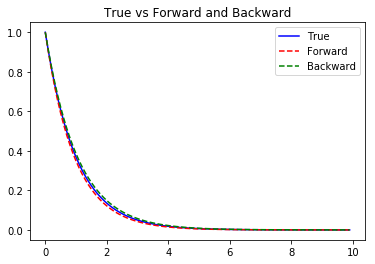

In [35]:
delta_t = .1
n = 100
lam = -1
y_0 = 1

ts = [delta_t * i for i in range(n)]
y_true = [foo(y_0, delta_t*i, lam) for i in range(n)]
y_forward = [forward(y_0, delta_t, lam, i) for i in range(n)]
y_backward = [backward(y_0, delta_t, lam, i) for i in range(n)]

plt.title('True vs Forward and Backward')
plt.plot(ts, y_true, '-b', label='True')
plt.plot(ts, y_forward, '--r', label='Forward')
plt.plot(ts, y_backward, '--g', label='Backward')
plt.legend()

In [100]:
target_t = 5
time_steps = [2**i for i in range(1,20)]
lam = -1
y_0 = 1

fw_errors = []
bk_errors = []

steps = [target_t/t for t in time_steps]

for step in time_steps:
    delta_t = target_t/step
    fw = forward(y_0, delta_t, lam, step)
    back = backward(y_0, delta_t, lam, step)
    true_value = foo(y_0, target_t, lam)
    fw_errors.append(np.abs(fw - true_value))
    bk_errors.append(np.abs(back - true_value))
    
print('fw_err\t\tfw_ratio\tback_err\tback_ratio')
print('%f\tN/A \t\t%f\tN/A  ' % (fw_errors[0], bk_errors[0]) )
for fw, fw_prev, bk, bk_prev in zip(fw_errors[1:], fw_errors[:-1], bk_errors[1:], bk_errors[:-1]):
    print('%f\t%f\t%f\t%f' % (fw, fw/fw_prev, bk, bk/bk_prev))
    
        


fw_err		fw_ratio	back_err	back_ratio
136.163159	N/A 		147.968715	N/A  
122.784253	0.901744	107.586841	0.727092
99.791819	0.812741	2408.699476	22.388421
70.861875	0.710097	253.041738	0.105053
44.263977	0.624652	81.285708	0.321234
25.152788	0.568245	33.972039	0.417934
13.475265	0.535736	15.654073	0.460793
6.984065	0.518288	7.527161	0.480844
3.556640	0.509251	3.692314	0.490532
1.794867	0.504652	1.828779	0.495293
0.901621	0.502333	0.910098	0.497654
0.451863	0.501168	0.453983	0.498828
0.226196	0.500584	0.226726	0.499415
0.113164	0.500292	0.113297	0.499707
0.056599	0.500146	0.056632	0.499854
0.028303	0.500073	0.028312	0.499927
0.014153	0.500037	0.014155	0.499963
0.007077	0.500018	0.007077	0.499982
0.003538	0.500009	0.003539	0.499991


In [19]:
l = zip(fw_errors[1:], fw_errors[:-1], bk_errors[1:], bk_errors[:-1])
for a, b, c, d in l:
    print(a,b,c,d)

0.09813016014842982 0.36787944117144233 0.07316613614786646 0.13212055882855767
0.04029005673169514 0.09813016014842982 0.03594125654955485 0.07316613614786646
0.018421153106358418 0.04029005673169514 0.017533267781211725 0.03594125654955485
0.00882228696598622 0.018421153106358418 0.00862363532858676 0.017533267781211725
0.004318736626198916 0.00882228696598622 0.004271903885053968 0.00862363532858676
0.00213681456395598 0.004318736626198916 0.002125455235711504 0.004271903885053968
0.0010628353081024722 0.00213681456395598 0.0010600387870733918 0.002125455235711504
0.0005300328463224702 0.0010628353081024722 0.000529339111767918 0.0010600387870733918


# Systems of ODEs

In [3]:
def solution_u(t):
    return (1+3*np.exp(-8/3*t))/8
def solution_v(t):
    return -3*np.exp(-8/3*t)

def solution(t):
    return np.array([solution_u(t), solution_v(t)])

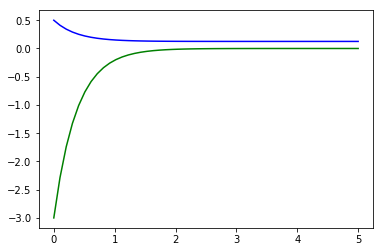

In [4]:
ts = np.linspace(0, 5)
plt.plot(ts, solution_u(ts), 'b-')
plt.plot(ts, solution_v(ts), 'g-')

In [29]:
def foo(z):
    u, v = z[0], z[1]
    return np.array((1/3 * v, v*(v-1)/(3*u)))

z0 = np.array([.5, -3])

def forward(delta_t, n):
    z = z0*1
    for i in range(n):
        z += delta_t * foo(z)
    return z

def backward(delta_t, n):
    A = delta_t/3
    u, v = z0[0], z0[1]
    for i in range(n):
        v = v*(u)/(u-A*v+A)
        u += A*v
    return np.array([u,v])

In [30]:
target_t = .5
time_steps = [2**i for i in range(1,20)]

fw_errors = []
bk_errors = []

steps = [target_t/t for t in time_steps]
true_value = solution(target_t)
for step in time_steps:
    delta_t = target_t/step
    fw = forward(delta_t, step)
    back = backward(delta_t, step)
    fw_errors.append(la.norm(fw - true_value))
    bk_errors.append(la.norm(back - true_value))
    
print('fw_err\t\tfw_ratio\tback_err\tback_ratio')
print('%f\tN/A \t\t%f\tN/A  ' % (fw_errors[0], bk_errors[0]) )
for fw, fw_prev, bk, bk_prev in zip(fw_errors[1:], fw_errors[:-1], bk_errors[1:], bk_errors[:-1]):
    print('%f\t%f\t%f\t%f' % (fw, fw/fw_prev, bk, bk/bk_prev))

fw_err		fw_ratio	back_err	back_ratio
0.461018	N/A 		0.291459	N/A  
0.199741	0.433261	0.159660	0.547796
0.093812	0.469666	0.083928	0.525667
0.045546	0.485503	0.043083	0.513337
0.022450	0.492907	0.021835	0.506803
0.011146	0.496491	0.010992	0.503436
0.005554	0.498255	0.005515	0.501727
0.002772	0.499130	0.002762	0.500866
0.001385	0.499565	0.001382	0.500433
0.000692	0.499783	0.000691	0.500217
0.000346	0.499891	0.000346	0.500108
0.000173	0.499946	0.000173	0.500054
0.000086	0.499973	0.000086	0.500027
0.000043	0.499986	0.000043	0.500014
0.000022	0.499993	0.000022	0.500007
0.000011	0.499997	0.000011	0.500003
0.000005	0.499998	0.000005	0.500002
0.000003	0.499999	0.000003	0.500000
0.000001	0.500000	0.000001	0.500004


# 1-D Heat Equation

In [172]:
from heat_equation import *
c = 1
def f(x):
    return x**2 * (1-x)

f = np.vectorize(f)
u = dirichlet_solution(c,f)


# Time-step n steps
def forward(u0, D, delta_t, num_steps):
    u = u0
    for i in range(num_steps):
        u = u + delta_t * D@u
    return u

def backward(u0, D, delta_t, num_steps):
    u = u0
    L = sp.eye(D.shape[0]) - delta_t*D
    for i in range(num_steps):
        u = spla.spsolve(L, u)
    return u

In [179]:
target_t = .1 # Time at which we are evaluating the error
time_steps = [2**i for i in range(2,8)] # List of the number of steps we are taking.

fw_errors = []
bk_errors = []

#steps = [target_t/n for n in time_steps] # lenght of a step
for num_steps in time_steps:
    delta_t = target_t/num_steps
    ###################################################################
    # Choice of n affects order of convergence
    
    n = num_steps
    #n = int(np.sqrt(num_steps))
    #n = int(num_steps**1.7)
        
    ###################################################################
    print('Processing num_steps=%d \t n=%d' % (num_steps, n) )
    h = 1/n
    D = sp.diags([1] + [-2]*(n-2) + [1]) + sp.diags([0] + [1]*(n-2), 1) + sp.diags([1]*(n-2) + [0], -1)
    D = h**-2 * D
    D[0,0] = 1
    D[n-1,n-1] = 1
    #print(D)
    xs = np.linspace(0,1, n)
    u0 = f(xs)
    true_value = u(xs, target_t)
    fw = forward(u0, D, delta_t, num_steps)
    back = backward(u0, D, delta_t, num_steps)
    fw_errors.append(la.norm(fw - true_value))
    bk_errors.append(la.norm(back - true_value))
    
print('fw_err       fw_ratio       back_err       back_ratio')
print('%10.5g        N/A       %10.5g       N/A  ' % (fw_errors[0], bk_errors[0]) )
for fw, fw_prev, bk, bk_prev in zip(fw_errors[1:], fw_errors[:-1], bk_errors[1:], bk_errors[:-1]):
    print('%10.5g    %10.5g    %10.5g    %10.5g' % (fw, fw/fw_prev, bk, bk/bk_prev) )

Processing num_steps=4 	 n=4
Processing num_steps=8 	 n=8
Processing num_steps=16 	 n=16
Processing num_steps=32 	 n=32
Processing num_steps=64 	 n=64
Processing num_steps=128 	 n=128
fw_err       fw_ratio       back_err       back_ratio
  0.038538        N/A         0.018017       N/A  
    0.5976        15.507       0.01556       0.86358
6.7522e+07    1.1299e+08      0.011875       0.76317
3.7128e+29    5.4987e+21     0.0086767       0.73069
2.8598e+83    7.7025e+53      0.006229        0.7179
       inf           inf     0.0044367       0.71227


In [168]:
type(D)

scipy.sparse.csr.csr_matrix

<IPython.core.display.Javascript object>


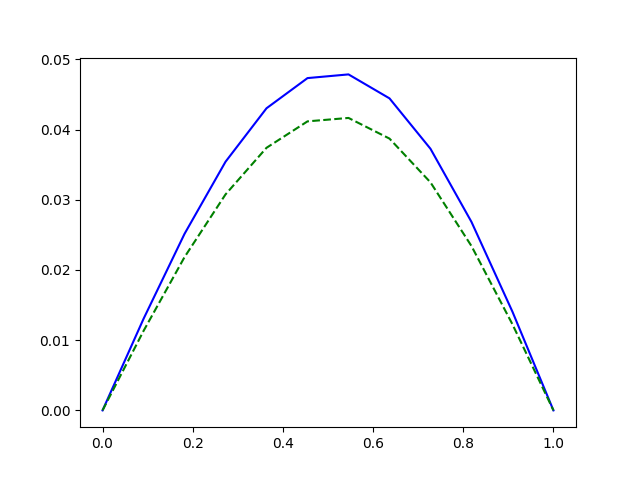

467.5454660284151


In [135]:
num_steps = 16
target_t = .1

delta_t = target_t/num_steps
h = np.sqrt(delta_t)
n = int(1/h)

#n = num_steps

##################################################################################

delta_t = target_t/num_steps
h = 1/n
D = sp.diags([1] + [-2]*(n-2) + [1]) + sp.diags([0] + [1]*(n-2), 1) + sp.diags([1]*(n-2) + [0], -1)
D = h**-2 * D
D[0,0] = 1
D[n-1,n-1] = 1
#print(D)
xs = np.linspace(0,1, n)
u0 = f(xs)
true_value = u(xs, target_t)
fw = forward(u0, D, delta_t, num_steps)
back = backward(u0, D, delta_t, num_steps)



plt.plot(xs, true_value, 'b-')
#plt.plot(xs, fw, 'r-.')
plt.plot(xs, back, 'g--')

print(np.max(np.abs( u0 - forward(u0, D, delta_t, num_steps) )))

# Animation Testing

<IPython.core.display.Javascript object>


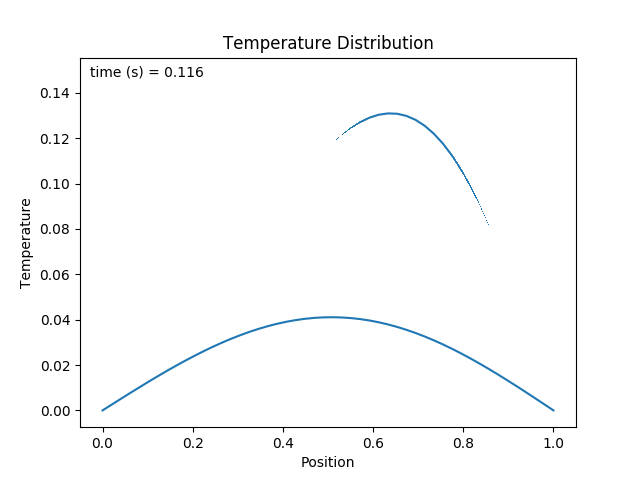

In [118]:
from heat_equation import *
def f(x):
    return x**2 * (1-x)
u = dirichlet_solution(1,f)
x = np.linspace(0,1)

import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()
plt.xlabel('Position')
plt.ylabel('Temperature')
plt.title('Temperature Distribution')

line, = ax.plot(x, f(x))
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)


def animate(i):
    line.set_ydata(u(x,i/1000))  # update the data
    time_text.set_text('time (s) = %.3f' % (i/1000))
    return line, time_text


# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    time_text.set_text('')
    return line, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init,
                              interval=25, blit=True)

ani.save('1D-heat.mp4', writer='imagemagick', fps=30)

plt.show()

In [31]:
fw_ratio = ['N/A'] + [e/p for e, p in zip(fw_errors[1:], fw_errors[:-1])]
bk_ratio = ['N/A'] + [e/p for e, p in zip(bk_errors[1:], bk_errors[:-1])]
print(html_table((steps, fw_errors, fw_ratio, bk_errors, bk_ratio), ('$\Delta t$', 'fw_err','fw_ratio','bk_err','bk_ratio')))

<table>
	<th>$\Delta t$</th>	<th>fw_err</th>	<th>fw_ratio</th>	<th>bk_err</th>	<th>bk_ratio</th>
	<tr>
		<td>0.25000000</td><td>0.46101812</td><td>N/A</td><td>0.29145927</td><td>N/A</td>
	</tr>
	<tr>
		<td>0.12500000</td><td>0.19974125</td><td>0.43326117</td><td>0.15966025</td><td>0.54779610</td>
	</tr>
	<tr>
		<td>0.06250000</td><td>0.09381172</td><td>0.46966624</td><td>0.08392814</td><td>0.52566712</td>
	</tr>
	<tr>
		<td>0.03125000</td><td>0.04554590</td><td>0.48550334</td><td>0.04308341</td><td>0.51333685</td>
	</tr>
	<tr>
		<td>0.01562500</td><td>0.02244991</td><td>0.49290732</td><td>0.02183481</td><td>0.50680318</td>
	</tr>
	<tr>
		<td>0.00781250</td><td>0.01114618</td><td>0.49649117</td><td>0.01099244</td><td>0.50343648</td>
	</tr>
	<tr>
		<td>0.00390625</td><td>0.00555364</td><td>0.49825479</td><td>0.00551520</td><td>0.50172712</td>
	</tr>
	<tr>
		<td>0.00195312</td><td>0.00277199</td><td>0.49912968</td><td>0.00276238</td><td>0.50086580</td>
	</tr>
	<tr>
		<td>0.00097656</td><t

In [82]:
isinstance('a', str)

True